In [1]:
import os.path as osp
import os
import random

from XASNet.utils import spectrum, batch_broadening
from XASNet.data import QM9_XAS

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2) 
rc('font', weight='normal')

params = {'legend.fontsize': 15,
          'figure.figsize': (10, 8),}
rcParams.update(params)

/home/xuewen/workdir/xasnet-copy/notebooks/XASNet/utils/ground_truth.py:39: SyntaxWarning: invalid escape sequence '\w'
  if re.match('\w+ ATOM POPULATIONS', line):
/home/xuewen/workdir/xasnet-copy/notebooks/XASNet/utils/ground_truth.py:42: SyntaxWarning: invalid escape sequence '\w'
  elif re.match('\w+ REDUCED ORBITAL POPULATIONS', line):
/home/xuewen/workdir/xasnet-copy/notebooks/XASNet/utils/ground_truth.py:80: SyntaxWarning: invalid escape sequence '\s'
  match1 = re.search('STATE\s*\d*[1-9]', line)


# Importing XAS spectra of 56k qm9 structures to label the data in QM9-XAS

In [3]:
data_spectra = np.load('qm9_Cedge_xas_56k.npz')

In [4]:
# printing the keys in the dataset
for key in data_spectra:
    print(key)

spec_stk
id


In [5]:
#XAS spectra 
spectra_stk = torch.tensor(data_spectra['spec_stk'])

# Seperating the spectra that has different shape than others
shape_lst = [312, 264, 216, 360, 312, 352, 440]
spectra1_stk = torch.split(spectra_stk[:2256,], shape_lst)
spectra2_stk = torch.stack(torch.split(spectra_stk[2256:,], 500))

## Visualise an example of the spectra 

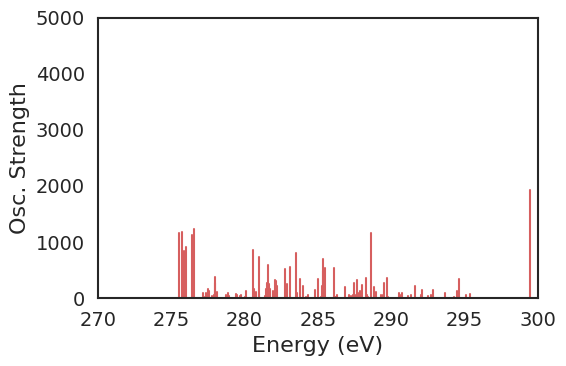

In [6]:
# energies and oscillator strength 
energies = spectra2_stk[100][:, 0]
osc = spectra2_stk[100][:, 1]

fig,ax=plt.subplots(figsize=(6,4))

for energy,osc_strength in zip(energies,osc):
    ax.plot((energy,energy),(0,osc_strength),c="r")
    
ax.set_xlabel("Energy (eV)",fontsize=16)
ax.xaxis.set_tick_params(labelsize=14,width=1.5)
ax.yaxis.set_tick_params(labelsize=14,width=1.5)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_xlim(270,300)
ax.set_ylim(0,5000)
ax.set_ylabel("Osc. Strength",fontsize=16)
plt.tight_layout()

### Broadening the spectra 

In [7]:
#Perform broadening on the spectrum 
x = torch.linspace(270, 300, 100)
sigma = torch.tensor(0.8)

gE = spectrum(
    energies,
    osc,
    sigma,
    x
)

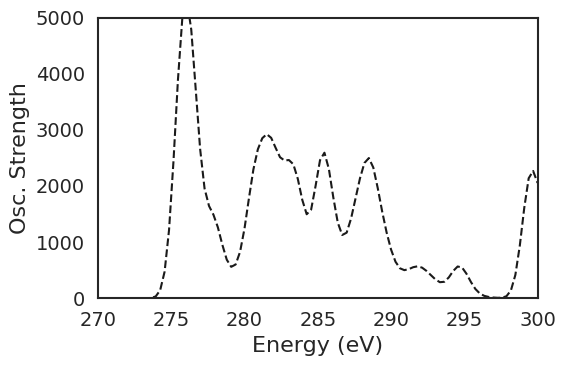

In [8]:
fig,ax=plt.subplots(figsize=(6,4))

ax.plot(x,gE,"--k")
ax.set_xlabel("Energy (eV)",fontsize=16)
ax.xaxis.set_tick_params(labelsize=14,width=1.5)
ax.yaxis.set_tick_params(labelsize=14,width=1.5)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
    
ax.set_xlim(270,300)
ax.set_ylim(0,5000)
ax.set_ylabel("Osc. Strength",fontsize=16)

plt.tight_layout()

# Batch broadening the spectra with fixed energy range

In [9]:
energies = torch.linspace(270, 300, 100)
sigma=torch.tensor(0.8)

broadened_spectra1 = batch_broadening(spectra1_stk, sigma, energies)
broadened_spectra2 = batch_broadening(spectra2_stk, sigma, energies)

100%|██████████| 55993/55993 [01:08<00:00, 811.69it/s] 


In [10]:
# merge the two batches of spectra 
broadened_spectra_stk = broadened_spectra1 + broadened_spectra2 

# Create QM9-XAS dataset

In [19]:
# the dataset can be either created or uploaded if already exists 
root = r'\\wsl$\Ubuntu\home\xuewen\workdir\xasnet-copy\notebooks'
qm9_spec = QM9_XAS(
    root=root,
    raw_dir='dataset',
    spectra=broadened_spectra_stk
)

# save the dataset if it doesn't exists
if not osp.exists(root):
    torch.save(qm9_spec, root)

Extracting dataset/qm9.zip
 42%|████▏     | 56000/133885 [00:24<00:33, 2318.28it/s]


RuntimeError: Parent directory \\wsl$\Ubuntu\home\xuewen\workdir\xasnet-copy does not exist.

In [20]:
osp.exists(root)

True

In [17]:
qm9_spec[2000]

Data(x=[18, 14], edge_index=[2, 36], edge_attr=[36, 5], pos=[18, 3], z=[18], spectrum=[100], idx=2000)

# Seperate train/val dataset from test dataset

In [ ]:
# shuffle the data first
qm9_spec = [graph for graph in qm9_spec]
random.shuffle(qm9_spec)

In [ ]:
# randomly picking the test dataset
qm9_spec_test = []
data_size = len(qm9_spec)
for i in range(6000):
    rand_idx = np.random.choice(data_size)
    qm9_spec_test.append(qm9_spec.pop(rand_idx))
    data_size -= 1

In [ ]:
# train/val dataset
gdata_50k = 'path-to-train-dataset'
if not osp.exists(gdata_50k):
    torch.save(qm9_spec, gdata_50k)

In [ ]:
# test dataset
gdata_test = 'path-to-test-dataset'
if not osp.exists(gdata_test):
    torch.save(qm9_spec_test, gdata_test)

In [ ]:
print(len(qm9_spec), len(qm9_spec_test))